# ScreenMind — Milestone 4: PyTorch MLP + Training Loop

**Goal:** Build, train, and evaluate a neural network on the preprocessed BRFSS data.

We train two models:
- **Classifier** — predict *high-risk* (>14 bad days) as a binary yes/no
- **Regressor** — predict the exact number of bad mental health days (0–30)

Steps:
1. Load processed data from `data/processed/`
2. Understand `Dataset` and `DataLoader`
3. Build the MLP architecture
4. Understand the loss functions and class imbalance fix
5. Train the classifier, plot learning curves
6. Evaluate on test set (AUC, F1, precision, recall)
7. Train the regressor
8. Evaluate on test set (MAE, RMSE, R²)

## 1. Imports & Load Data

In [2]:
import sys
sys.path.insert(0, '..')   # make src/ importable from notebooks/

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from src.data.preprocessing import load_processed, FEATURE_COLS
from src.models.mlp import MLP
from src.training.trainer import (
    BRFSSDataset, make_loaders, make_criterion, train,
    evaluate_clf, evaluate_reg,
)

sns.set_theme(style='whitegrid', palette='muted')

PROCESSED_DIR = '../data/processed'
MODELS_DIR    = '../data/models'

# ── Load preprocessed splits ──────────────────────────────────────────────────
data = load_processed(PROCESSED_DIR)

print('Loaded splits:')
for key, val in data.items():
    if hasattr(val, 'shape'):
        print(f'  {key:<18} shape={val.shape}  dtype={val.dtype}')
    else:
        print(f'  {key:<18} {type(val).__name__}')

print(f'\nDevice: {"cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"}')
print(f'PyTorch version: {torch.__version__}')

Loaded splits:
  X_train            shape=(314659, 15)  dtype=float32
  X_val              shape=(67427, 15)  dtype=float32
  X_test             shape=(67428, 15)  dtype=float32
  y_reg_train        shape=(314659,)  dtype=float32
  y_reg_val          shape=(67427,)  dtype=float32
  y_reg_test         shape=(67428,)  dtype=float32
  y_clf_train        shape=(314659,)  dtype=float32
  y_clf_val          shape=(67427,)  dtype=float32
  y_clf_test         shape=(67428,)  dtype=float32
  scaler             StandardScaler
  imputer            SimpleImputer

Device: cpu
PyTorch version: 2.10.0+cpu


## 2. Dataset and DataLoader

### What is a Dataset?

PyTorch's `Dataset` is a simple contract: an object that knows
how many examples it has (`__len__`) and can return any one of them
by index (`__getitem__`).  Our `BRFSSDataset` wraps the numpy arrays
and converts them to PyTorch tensors on the fly.

### What is a DataLoader?

Training on 314k examples at once would require enormous memory.
Instead we train in **mini-batches** — small random subsets (e.g. 512 rows).

`DataLoader` handles this automatically:
- Shuffles the data each epoch (so the model doesn't see examples in the same order)
- Splits into batches of `batch_size`
- Returns an iterator you can loop over

**Why batch size 512?**  
Too small (e.g. 32): noisy gradients, slow training.  
Too large (e.g. 8192): smoother gradients but less regularisation, can overfit.  
512 is a sweet spot for this dataset size on CPU.

In [3]:
# Classification loaders
train_loader_clf, val_loader_clf, test_loader_clf = make_loaders(
    data, task='clf', batch_size=512
)

# Regression loaders
train_loader_reg, val_loader_reg, test_loader_reg = make_loaders(
    data, task='reg', batch_size=512
)

# Peek at one batch to understand the shapes
X_batch, y_batch = next(iter(train_loader_clf))
print('One training batch:')
print(f'  X_batch shape: {X_batch.shape}   ← (batch_size=512, n_features=15)')
print(f'  y_batch shape: {y_batch.shape}   ← (batch_size=512,) — one label per row')
print(f'  X_batch dtype: {X_batch.dtype}')
print(f'  y_batch values (first 10): {y_batch[:10].numpy()}')
print()
n_batches = len(train_loader_clf)
print(f'Training batches per epoch: {n_batches}  '
      f'(= {len(train_loader_clf.dataset):,} samples / 512 batch size)')

One training batch:
  X_batch shape: torch.Size([512, 15])   ← (batch_size=512, n_features=15)
  y_batch shape: torch.Size([512])   ← (batch_size=512,) — one label per row
  X_batch dtype: torch.float32
  y_batch values (first 10): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]

Training batches per epoch: 615  (= 314,659 samples / 512 batch size)


## 3. The MLP Architecture

### Architecture recap

```
Input (15 features)
  → Linear(15 → 128)  +  BatchNorm1d(128)  +  ReLU  +  Dropout(0.3)
  → Linear(128 → 64)  +  BatchNorm1d(64)   +  ReLU  +  Dropout(0.3)
  → Linear(64 → 1)
  → raw scalar output  (no final activation)
```

**BatchNorm1d:** normalises the output of each layer to roughly zero mean
and unit variance across the mini-batch. This keeps the activations in a
healthy range throughout the network and makes training more stable.

**ReLU:** max(0, x). Introduces non-linearity. Without it, the entire
network collapses to a single linear function no matter how many layers.

**Dropout(0.3):** randomly sets 30% of the activations to zero during each
forward pass. At test time, all neurons are active. This forces the network
to learn robust features rather than memorising the training data.

In [4]:
model_clf = MLP(input_dim=15, hidden_dims=[128, 64], dropout=0.3, task='clf')
print(model_clf)
print()

model_reg = MLP(input_dim=15, hidden_dims=[128, 64], dropout=0.3, task='reg')
print(f'Classifier parameters:  {model_clf.count_parameters():,}')
print(f'Regressor parameters:   {model_reg.count_parameters():,}')
print()
print('Parameter count breakdown (classifier):')
for name, param in model_clf.named_parameters():
    print(f'  {name:<35} {str(tuple(param.shape)):>15}  →  {param.numel():,} params')

MLP(task='clf', params=10,753)
MLP(
  (network): Sequential(
    (0): Linear(in_features=15, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=64, out_features=1, bias=True)
  )
)

Classifier parameters:  10,753
Regressor parameters:   10,753

Parameter count breakdown (classifier):
  network.0.weight                          (128, 15)  →  1,920 params
  network.0.bias                               (128,)  →  128 params
  network.1.weight                             (128,)  →  128 params
  network.1.bias                               (128,)  →  128 params
  network.4.weight                          (64, 128)  →  8,192 params
  network.

## 4. Loss Functions and Class Imbalance

### Classification: BCEWithLogitsLoss

BCE = Binary Cross-Entropy. For a single prediction:
```
loss = -[ y · log(p) + (1-y) · log(1-p) ]
```
where `p` is the predicted probability and `y` is the true label (0 or 1).

- If `y=1` (high-risk) and the model predicts `p=0.9` → small loss  
- If `y=1` (high-risk) and the model predicts `p=0.1` → large loss  

**`BCEWithLogitsLoss`** takes raw logits (before sigmoid) and applies
the sigmoid internally — this is numerically more stable than
applying sigmoid ourselves and then passing to BCELoss.

### The class imbalance problem

86.8% of respondents are *not* high-risk. A model that predicts
"low-risk" for every single person would get **86.8% accuracy** while
being completely useless clinically.

**Fix: `pos_weight`**  
We tell the loss function that missing a high-risk case should cost more:
```
pos_weight = n_negative / n_positive  ≈  390k / 59k  ≈  6.6
```
Now the loss for a false negative (missed high-risk) is 6.6× the loss
for a false positive.  The model is forced to learn to identify high-risk cases.

### Regression: MSELoss
```
loss = mean( (predicted_days - true_days)² )
```
Penalises large errors quadratically — being off by 10 days costs 100× more
than being off by 1 day.

In [5]:
criterion_clf = make_criterion('clf', data['y_clf_train'])
criterion_reg = make_criterion('reg', data['y_reg_train'])

n_pos = data['y_clf_train'].sum()
n_neg = len(data['y_clf_train']) - n_pos

print('Classification loss:')
print(f'  Criterion:   {criterion_clf}')
print(f'  n_positive:  {n_pos:,.0f}  ({n_pos/len(data["y_clf_train"])*100:.1f}%)')
print(f'  n_negative:  {n_neg:,.0f}  ({n_neg/len(data["y_clf_train"])*100:.1f}%)')
print(f'  pos_weight:  {n_neg/n_pos:.2f}x  ← missing a high-risk case costs this much more')
print()
print('Regression loss:')
print(f'  Criterion:   {criterion_reg}')

Classification loss:
  Criterion:   BCEWithLogitsLoss()
  n_positive:  41,627  (13.2%)
  n_negative:  273,032  (86.8%)
  pos_weight:  6.56x  ← missing a high-risk case costs this much more

Regression loss:
  Criterion:   MSELoss()


## 5. Train the Classifier

The training loop:
1. For each epoch, iterate over all batches (one pass = one epoch)
2. Compute loss → backprop → update weights
3. After each epoch, compute validation loss (no weight updates)
4. If val loss improves → save checkpoint
5. If no improvement for `patience=10` epochs → stop early

**Adam optimizer:** a more sophisticated version of gradient descent.
It adapts the learning rate per-parameter based on recent gradient history.
Much less sensitive to the exact `lr` value than plain SGD.

In [6]:
import os
os.makedirs(MODELS_DIR, exist_ok=True)

history_clf = train(
    model=model_clf,
    train_loader=train_loader_clf,
    val_loader=val_loader_clf,
    criterion=criterion_clf,
    checkpoint_path=f'{MODELS_DIR}/clf_best.pt',
    lr=1e-3,
    max_epochs=100,
    patience=10,
)

Training on cpu  |  max_epochs=100  |  patience=10
 Epoch    Train Loss      Val Loss    Best
--------------------------------------------
     1       0.86179       0.83061   ✓
     2       0.84477       0.83108  
     3       0.84219       0.82928   ✓
     4       0.84079       0.82935  
     5       0.84006       0.82855   ✓
     6       0.83870       0.82780   ✓
     7       0.83847       0.82873  
     8       0.83810       0.82852  
     9       0.83730       0.82948  
    10       0.83621       0.82717   ✓
    11       0.83662       0.82789  
    12       0.83579       0.82766  
    13       0.83569       0.82728  
    14       0.83503       0.82782  
    15       0.83484       0.82676   ✓
    16       0.83514       0.82634   ✓
    17       0.83528       0.82701  
    18       0.83480       0.82722  
    19       0.83436       0.82725  
    20       0.83499       0.82732  
    21       0.83345       0.82674  
    22       0.83366       0.82683  
    23       0.83399       0.8271

## 6. Plot Classifier Training Curves

**What to look for:**
- Both curves falling together → the model is learning
- Val loss starts rising while train loss keeps falling → overfitting began
- Val loss is lower than train loss early on → normal (dropout is off at eval time)

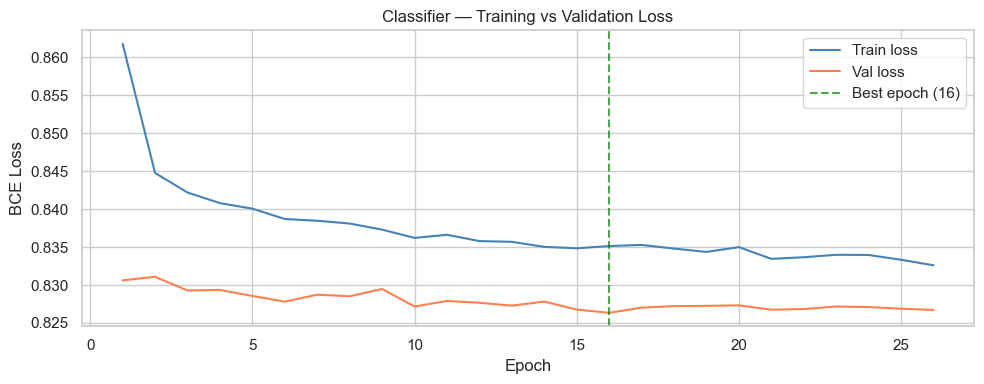

Best val loss: 0.82634  at epoch 16


In [7]:
fig, ax = plt.subplots(figsize=(10, 4))
epochs = range(1, len(history_clf['train_loss']) + 1)
ax.plot(epochs, history_clf['train_loss'], label='Train loss', color='steelblue')
ax.plot(epochs, history_clf['val_loss'],   label='Val loss',   color='coral')

best_epoch = int(np.argmin(history_clf['val_loss'])) + 1
ax.axvline(best_epoch, color='green', linestyle='--', alpha=0.7, label=f'Best epoch ({best_epoch})')

ax.set_xlabel('Epoch')
ax.set_ylabel('BCE Loss')
ax.set_title('Classifier — Training vs Validation Loss')
ax.legend()
plt.tight_layout()
plt.show()

print(f'Best val loss: {min(history_clf["val_loss"]):.5f}  at epoch {best_epoch}')

## 7. Evaluate Classifier on Test Set

We load the *best* checkpoint (saved during training) and evaluate on the
held-out test set that was never touched during training or validation.

**Metrics explained:**

| Metric | Formula | Meaning |
|--------|---------|-------|
| Accuracy | (TP+TN)/(TP+TN+FP+FN) | Overall % correct — misleading with imbalanced classes |
| Precision | TP/(TP+FP) | Of those we flagged high-risk, how many really were? |
| Recall | TP/(TP+FN) | Of all high-risk patients, how many did we catch? |
| F1 | 2·P·R/(P+R) | Harmonic mean of precision and recall |
| ROC-AUC | — | Probability that model ranks a random positive above a random negative (0.5=random, 1.0=perfect) |

In a clinical mental health context, **recall** (catching all high-risk patients)
is often more important than precision (avoiding false alarms).

In [8]:
# Load the best checkpoint
model_clf.load_state_dict(torch.load(f'{MODELS_DIR}/clf_best.pt', weights_only=True))

metrics_clf = evaluate_clf(model_clf, test_loader_clf)

print('=== Classifier Test Set Metrics ===')
print(f'  Accuracy:   {metrics_clf["accuracy"]*100:.2f}%')
print(f'  Precision:  {metrics_clf["precision"]*100:.2f}%   ← of flagged high-risk, how many were really?')
print(f'  Recall:     {metrics_clf["recall"]*100:.2f}%   ← of true high-risk, how many did we catch?')
print(f'  F1:         {metrics_clf["f1"]*100:.2f}%')
print(f'  ROC-AUC:    {metrics_clf["roc_auc"]:.4f}   ← 0.5=random, 1.0=perfect')
print(f'  Samples:    {metrics_clf["n_samples"]:,}')

=== Classifier Test Set Metrics ===
  Accuracy:   78.17%
  Precision:  35.24%   ← of flagged high-risk, how many were really?
  Recall:     77.60%   ← of true high-risk, how many did we catch?
  F1:         48.47%
  ROC-AUC:    0.8564   ← 0.5=random, 1.0=perfect
  Samples:    67,428


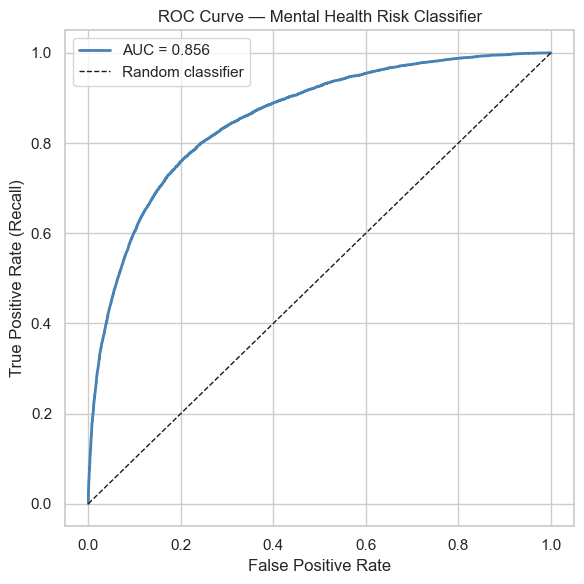

In [9]:
# ROC curve
from sklearn.metrics import roc_curve
from src.training.trainer import _get_predictions

logits, labels = _get_predictions(model_clf, test_loader_clf, device='cpu')
probs = 1 / (1 + np.exp(-logits))
fpr, tpr, _ = roc_curve(labels.astype(int), probs)

fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(fpr, tpr, color='steelblue', lw=2, label=f'AUC = {metrics_clf["roc_auc"]:.3f}')
ax.plot([0, 1], [0, 1], 'k--', lw=1, label='Random classifier')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate (Recall)')
ax.set_title('ROC Curve — Mental Health Risk Classifier')
ax.legend()
plt.tight_layout()
plt.show()

## 8. Train the Regressor

Same architecture, same training loop — only the loss function changes.
`MSELoss` penalises the squared difference between predicted and true day count.

This is a harder task: the distribution is zero-inflated (60% zeros),
so the model will tend to predict low values.  We'll explore loss weighting
variants in Milestone 5.

In [10]:
history_reg = train(
    model=model_reg,
    train_loader=train_loader_reg,
    val_loader=val_loader_reg,
    criterion=criterion_reg,
    checkpoint_path=f'{MODELS_DIR}/reg_best.pt',
    lr=1e-3,
    max_epochs=100,
    patience=10,
)

Training on cpu  |  max_epochs=100  |  patience=10
 Epoch    Train Loss      Val Loss    Best
--------------------------------------------
     1      50.43519      45.97323   ✓
     2      47.27079      45.92795   ✓
     3      47.00307      45.72286   ✓
     4      46.88237      45.71231   ✓
     5      46.80713      45.66210   ✓
     6      46.76521      45.63975   ✓
     7      46.65525      45.63876   ✓
     8      46.61198      45.63015   ✓
     9      46.62008      45.60482   ✓
    10      46.54420      45.74943  
    11      46.53257      45.59504   ✓
    12      46.48809      45.62129  
    13      46.54303      45.58642   ✓
    14      46.47594      45.63616  
    15      46.45218      45.57293   ✓
    16      46.41608      45.58698  
    17      46.41914      45.71326  
    18      46.41202      45.63622  
    19      46.41610      45.57609  
    20      46.38233      45.58660  
    21      46.37118      45.55665   ✓
    22      46.38744      45.54857   ✓
    23      46.4253

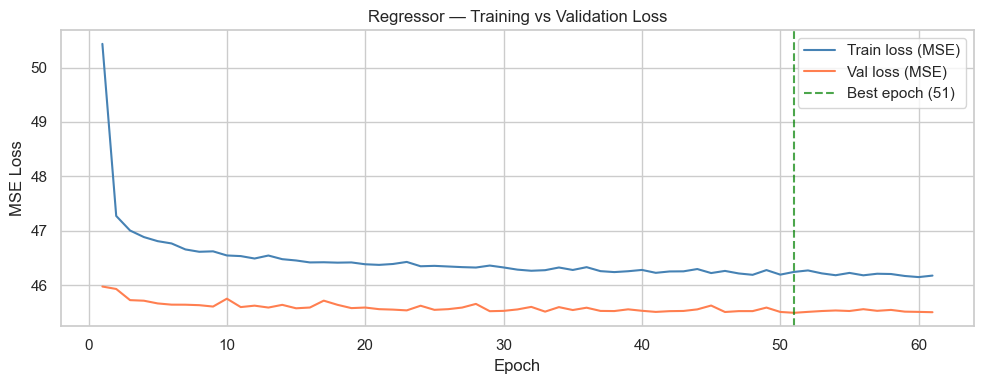

In [11]:
fig, ax = plt.subplots(figsize=(10, 4))
epochs = range(1, len(history_reg['train_loss']) + 1)
ax.plot(epochs, history_reg['train_loss'], label='Train loss (MSE)', color='steelblue')
ax.plot(epochs, history_reg['val_loss'],   label='Val loss (MSE)',   color='coral')

best_epoch_reg = int(np.argmin(history_reg['val_loss'])) + 1
ax.axvline(best_epoch_reg, color='green', linestyle='--', alpha=0.7,
           label=f'Best epoch ({best_epoch_reg})')
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE Loss')
ax.set_title('Regressor — Training vs Validation Loss')
ax.legend()
plt.tight_layout()
plt.show()

## 9. Evaluate Regressor on Test Set

**Metrics:**
- **MAE** (Mean Absolute Error): average absolute difference in days — easy to interpret
- **RMSE** (Root Mean Squared Error): penalises large errors more — same units as MAE
- **R²**: proportion of variance explained. 0 = no better than predicting the mean; 1 = perfect

Baseline to beat: predicting the mean (~4.4 days) for everyone gives MAE ≈ 5.8 days, R² = 0.0.

In [12]:
model_reg.load_state_dict(torch.load(f'{MODELS_DIR}/reg_best.pt', weights_only=True))

metrics_reg = evaluate_reg(model_reg, test_loader_reg)

print('=== Regressor Test Set Metrics ===')
print(f'  MAE:   {metrics_reg["mae"]:.3f} days   ← average absolute error')
print(f'  RMSE:  {metrics_reg["rmse"]:.3f} days')
print(f'  R²:    {metrics_reg["r2"]:.4f}        ← 0=baseline, 1=perfect')
print(f'  Samples: {metrics_reg["n_samples"]:,}')
print()
mean_days = data['y_reg_test'].mean()
baseline_mae = np.abs(data['y_reg_test'] - mean_days).mean()
print(f'Baseline (always predict mean={mean_days:.1f}d): MAE = {baseline_mae:.3f}')
print(f'Our model improves MAE by {(baseline_mae - metrics_reg["mae"]):.3f} days')

=== Regressor Test Set Metrics ===
  MAE:   4.166 days   ← average absolute error
  RMSE:  6.722 days
  R²:    0.3517        ← 0=baseline, 1=perfect
  Samples: 67,428

Baseline (always predict mean=4.4d): MAE = 5.916
Our model improves MAE by 1.750 days


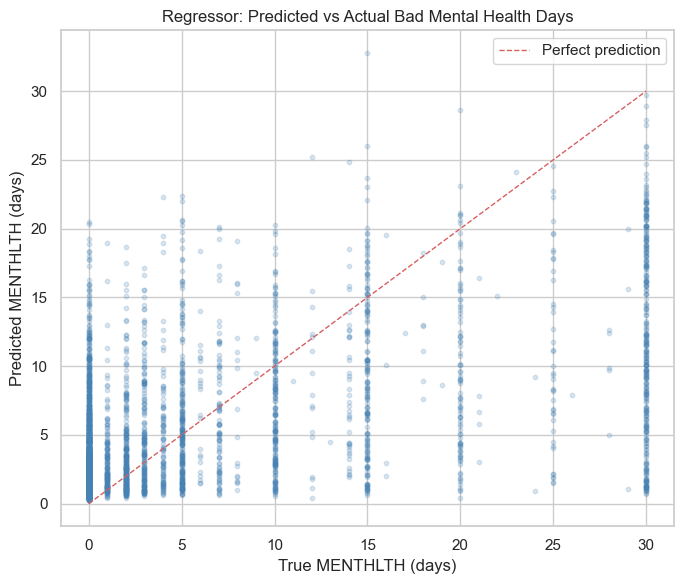

Note: zero-inflation compresses predictions toward low values — addressed in Milestone 5.


In [13]:
# Scatter: predicted vs actual
preds, labels = _get_predictions(model_reg, test_loader_reg, device='cpu')

# Sample 5000 points to keep the plot readable
rng = np.random.default_rng(42)
idx = rng.choice(len(preds), size=5000, replace=False)

fig, ax = plt.subplots(figsize=(7, 6))
ax.scatter(labels[idx], preds[idx], alpha=0.2, s=10, color='steelblue')
ax.plot([0, 30], [0, 30], 'r--', lw=1, label='Perfect prediction')
ax.set_xlabel('True MENTHLTH (days)')
ax.set_ylabel('Predicted MENTHLTH (days)')
ax.set_title('Regressor: Predicted vs Actual Bad Mental Health Days')
ax.legend()
plt.tight_layout()
plt.show()
print('Note: zero-inflation compresses predictions toward low values — addressed in Milestone 5.')

## 10. Milestone 4 Summary

In [14]:
print('=' * 60)
print('MILESTONE 4 SUMMARY — PyTorch MLP + Training Loop')
print('=' * 60)
print()
print('ARCHITECTURE:')
print(f'  Input(15) → Linear(128)+BN+ReLU+Drop → Linear(64)+BN+ReLU+Drop → Linear(1)')
print(f'  Parameters: {model_clf.count_parameters():,}')
print()
print('CLASSIFIER RESULTS (test set):')
print(f'  AUC:       {metrics_clf["roc_auc"]:.4f}')
print(f'  F1:        {metrics_clf["f1"]:.4f}')
print(f'  Recall:    {metrics_clf["recall"]:.4f}  ← high-risk patients caught')
print(f'  Precision: {metrics_clf["precision"]:.4f}')
print()
print('REGRESSOR RESULTS (test set):')
print(f'  MAE:  {metrics_reg["mae"]:.3f} days')
print(f'  RMSE: {metrics_reg["rmse"]:.3f} days')
print(f'  R²:   {metrics_reg["r2"]:.4f}')
print()
print('SAVED ARTIFACTS:')
print('  data/models/clf_best.pt   — best classifier weights')
print('  data/models/reg_best.pt   — best regressor weights')
print()
print('NEXT: Milestone 5 — Weights & Biases experiment tracking')
print('  We will train 3 variants and compare them on a W&B dashboard:')
print('  Variant A: this baseline (pos_weight + plain MSE)')
print('  Variant B: larger MLP (256 → 128 → 64)')
print('  Variant C: weighted MSE regression (penalise high-day predictions more)')

MILESTONE 4 SUMMARY — PyTorch MLP + Training Loop

ARCHITECTURE:
  Input(15) → Linear(128)+BN+ReLU+Drop → Linear(64)+BN+ReLU+Drop → Linear(1)
  Parameters: 10,753

CLASSIFIER RESULTS (test set):
  AUC:       0.8564
  F1:        0.4847
  Recall:    0.7760  ← high-risk patients caught
  Precision: 0.3524

REGRESSOR RESULTS (test set):
  MAE:  4.166 days
  RMSE: 6.722 days
  R²:   0.3517

SAVED ARTIFACTS:
  data/models/clf_best.pt   — best classifier weights
  data/models/reg_best.pt   — best regressor weights

NEXT: Milestone 5 — Weights & Biases experiment tracking
  We will train 3 variants and compare them on a W&B dashboard:
  Variant A: this baseline (pos_weight + plain MSE)
  Variant B: larger MLP (256 → 128 → 64)
  Variant C: weighted MSE regression (penalise high-day predictions more)
